# CODICE FUNZIONANTE CON SCORE MIGLIORE (6859)

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.base import clone
import io
import warnings
from datetime import datetime, timedelta
import re
import gc
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Gestione Warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None
# --- Inizio del Notebook ---

print("Progetto di Machine Learning (v14 - Previsione Ricorsiva MPE)")
print("="*60)

# --- 1. Metrica di Valutazione ---
print("\n--- Sezione 1: Definizione Metrica ---")
def quantile_error(y_true, y_pred, q=0.2):
    error = y_true - y_pred
    return np.mean(np.maximum(q * error, (q - 1) * error))
print("Metrica Quantile Error definita.")

# --- 2. Caricamento e Preparazione Dati ---
print("\n--- Sezione 2: Caricamento e Cleaning Dati ---")
df_receivals = pd.read_csv("data/kernel/receivals.csv")
df_po = pd.read_csv("data/kernel/purchase_orders.csv")
df_materials = pd.read_csv("data/extended/materials.csv")
df_mapping = pd.read_csv("data/prediction_mapping.csv")

# --- 2.1. Cleaning e Preparazione Base ---
df_receivals['date'] = pd.to_datetime(df_receivals['date_arrival'], utc=True, errors='coerce').dt.tz_localize(None).dt.normalize()
df_receivals = df_receivals.dropna(subset=['date', 'rm_id', 'net_weight'])
df_receivals = df_receivals[df_receivals['net_weight'] > 0]
pred_start_date_dt = datetime.strptime('2025-01-01', '%Y-%m-%d')
pred_end_date_dt = datetime.strptime('2025-05-31', '%Y-%m-%d')
end_of_2024 = datetime.strptime('2024-12-31', '%Y-%m-%d')

df_receivals_hist = df_receivals[df_receivals['date'] < pred_start_date_dt].copy()
df_receivals_hist['rm_id'] = df_receivals_hist['rm_id'].astype(int)
df_daily_target = df_receivals_hist.groupby(['rm_id', 'date'])['net_weight'].sum().reset_index()

# Prepara PO con split corretto (questa non è utile ma viene utilizzate per il filtro euristico)
print("Preparazione feature PO (con split corretto)...")
df_mat_map = df_materials[['product_id', 'rm_id']].drop_duplicates().dropna()
df_split_count = df_mat_map.groupby('product_id')['rm_id'].nunique().reset_index(name='n_splits')
df_mat_map = pd.merge(df_mat_map, df_split_count, on='product_id', how='left')
df_po_merged = pd.merge(df_po, df_mat_map, on='product_id', how='left')
df_po_merged = df_po_merged.dropna(subset=['rm_id', 'n_splits'])
df_po_merged['rm_id'] = df_po_merged['rm_id'].astype(int)
df_po_merged['date'] = pd.to_datetime(df_po_merged['delivery_date'], utc=True, errors='coerce').dt.tz_localize(None).dt.normalize()
df_po_merged = df_po_merged[df_po_merged['quantity'] > 0]
df_po_merged = df_po_merged.dropna(subset=['date'])
df_po_merged['quantity_split'] = df_po_merged['quantity'] / df_po_merged['n_splits']
df_po_agg = df_po_merged.groupby(['rm_id', 'date'])['quantity_split'].sum().reset_index()
df_po_agg.rename(columns={'quantity_split': 'po_agg_qty_split'}, inplace=True)


# --- 2.2. Filtro Attività Euristico ---
print("\n--- Sezione 2.2: Filtro Attività Euristico ---")
RECENT_DATE_CUTOFF = datetime.strptime('2023-01-01', '%Y-%m-%d')
rm_ids_consegne_recenti = df_daily_target[df_daily_target['date'] >= RECENT_DATE_CUTOFF]['rm_id'].unique()
rm_ids_po_futuri = df_po_agg[df_po_agg['date'] >= pred_start_date_dt]['rm_id'].unique()
active_rm_ids = np.union1d(rm_ids_consegne_recenti, rm_ids_po_futuri)
print(f"Totale rm_id 'ATTIVI' identificati (euristico): {len(active_rm_ids)}")

# --- 3. Feature Engineering (Globale per MPE) ---
print("\n--- Sezione 3: Feature Engineering Globale per MPE ---")

# --- 3.1: Creazione Griglia Dati Completa (Solo Attivi) ---
min_date_hist = df_daily_target['date'].min() if not df_daily_target.empty else datetime.strptime('2022-01-01', '%Y-%m-%d')
all_dates_hist = pd.date_range(start=min_date_hist, end=end_of_2024, freq='D')
df_grid_hist_mpe = pd.MultiIndex.from_product([active_rm_ids, all_dates_hist], names=['rm_id', 'date'])
df_grid_hist_mpe = pd.DataFrame(index=df_grid_hist_mpe).reset_index()
df_grid_hist_mpe['rm_id'] = df_grid_hist_mpe['rm_id'].astype(int)
df_train_full_mpe = pd.merge(df_grid_hist_mpe, df_daily_target, on=['rm_id', 'date'], how='left')
df_train_full_mpe['net_weight'] = df_train_full_mpe['net_weight'].fillna(0)

# --- 3.2: Creazione DataFrame "Master" (Solo Attivi) ---
all_dates_pred = pd.date_range(start=pred_start_date_dt, end=pred_end_date_dt, freq='D')
df_grid_pred_mpe = pd.MultiIndex.from_product([active_rm_ids, all_dates_pred], names=['rm_id', 'date'])
df_grid_pred_mpe = pd.DataFrame(index=df_grid_pred_mpe).reset_index()
df_grid_pred_mpe['rm_id'] = df_grid_pred_mpe['rm_id'].astype(int)
df_master_mpe = pd.concat([df_train_full_mpe, df_grid_pred_mpe], ignore_index=True)
df_master_mpe['date'] = pd.to_datetime(df_master_mpe['date'])
df_master_mpe.sort_values(by=['rm_id', 'date'], inplace=True)

# --- 3.3: Unione e Creazione Feature ---
print("Unione PO e creazione feature (date, lag, roll)...")
df_master_mpe = pd.merge(df_master_mpe, df_po_agg, on=['rm_id', 'date'], how='left')
df_master_mpe['po_agg_qty_split'] = df_master_mpe['po_agg_qty_split'].fillna(0)
df_master_mpe.rename(columns={'po_agg_qty_split': 'po_expected_quantity'}, inplace=True)

df_master_mpe['dayofweek'] = df_master_mpe['date'].dt.dayofweek
df_master_mpe['month'] = df_master_mpe['date'].dt.month
df_master_mpe['dayofyear'] = df_master_mpe['date'].dt.dayofyear
df_master_mpe['year'] = df_master_mpe['date'].dt.year
df_master_mpe['weekofyear'] = df_master_mpe['date'].dt.isocalendar().week.astype(int)
df_master_mpe['is_weekend'] = (df_master_mpe['dayofweek'] >= 5).astype(int)

# Feature PO (calcolate ma ESCLUSE dall'addestramento)
df_master_mpe['po_roll_mean_7'] = df_master_mpe.groupby('rm_id')['po_expected_quantity'].transform(lambda x: x.rolling(7, 1).mean())
df_master_mpe['po_roll_sum_7'] = df_master_mpe.groupby('rm_id')['po_expected_quantity'].transform(lambda x: x.rolling(7, 1).sum())

# Lag Target - AGGIUNTA DEI NUOVI LAG
LAGS_MPE = [7, 14, 28, 30, 91, 182, 270, 364] 
for lag in LAGS_MPE:
     df_master_mpe[f'lag_{lag}'] = df_master_mpe.groupby('rm_id')['net_weight'].shift(lag)

# ✅ FIX DATA LEAKAGE: Calcola rolling features SOLO su dati storici
print("Calcolo rolling features su dati storici (fix leakage)...")
df_hist_only = df_master_mpe[df_master_mpe['date'] < pred_start_date_dt].copy()

# Rolling Target (calcolate solo su storico)
df_hist_only[f'lag_7_roll_mean_14'] = df_hist_only.groupby('rm_id')[f'lag_7'].transform(lambda x: x.rolling(14, 7).mean())
df_hist_only[f'lag_364_roll_mean_7'] = df_hist_only.groupby('rm_id')[f'lag_364'].transform(lambda x: x.rolling(7, 1).mean())
df_hist_only[f'lag_30_roll_mean_90'] = df_hist_only.groupby('rm_id')[f'lag_30'].transform(lambda x: x.rolling(90, 30).mean())

# Merge back nel dataframe master (futuro avrà NaN, verranno popolati in ricorsione)
df_master_mpe = pd.merge(
    df_master_mpe,
    df_hist_only[['rm_id', 'date', 'lag_7_roll_mean_14', 'lag_364_roll_mean_7', 'lag_30_roll_mean_90']],
    on=['rm_id', 'date'],
    how='left'
)

print("Rolling features calcolate correttamente (no leakage).")


# --- DEFINIZIONE FINALE DELLE FEATURE ---
mpe_features = [col for col in df_master_mpe.columns if col not in ['net_weight', 'date', 'rm_id'] and 'po_' not in col]
categorical_features_mpe = ['dayofweek', 'month', 'weekofyear', 'is_weekend']
categorical_features_mpe = [col for col in categorical_features_mpe if col in mpe_features]

print("Feature engineering globale completata.")




Progetto di Machine Learning (v14 - Previsione Ricorsiva MPE)

--- Sezione 1: Definizione Metrica ---
Metrica Quantile Error definita.

--- Sezione 2: Caricamento e Cleaning Dati ---
Preparazione feature PO (con split corretto)...

--- Sezione 2.2: Filtro Attività Euristico ---
Totale rm_id 'ATTIVI' identificati (euristico): 121

--- Sezione 3: Feature Engineering Globale per MPE ---
Preparazione feature PO (con split corretto)...

--- Sezione 2.2: Filtro Attività Euristico ---
Totale rm_id 'ATTIVI' identificati (euristico): 121

--- Sezione 3: Feature Engineering Globale per MPE ---
Unione PO e creazione feature (date, lag, roll)...
Unione PO e creazione feature (date, lag, roll)...
Calcolo rolling features su dati storici (fix leakage)...
Calcolo rolling features su dati storici (fix leakage)...
Rolling features calcolate correttamente (no leakage).
Feature engineering globale completata.
Rolling features calcolate correttamente (no leakage).
Feature engineering globale completata.


# 📊 Exploratory Data Analysis (EDA)

## Obiettivo dell'Analisi
Comprendere la distribuzione, le caratteristiche temporali e i pattern dei ricevimenti di materiali grezzi per costruire un modello predittivo conservativo che minimizzi il rischio di sovrastima nel Quantile Error (q=0.2).

---


=== EDA 1: ANALISI TEMPORALE DEI RICEVIMENTI ===

Ricevimenti mensili (ultimi 12 mesi):
    year_month        sum  count          mean
235 2024-01-01  6259731.0    419  14939.692124
236 2024-02-01  7636180.0    527  14489.905123
237 2024-03-01  7488263.0    528  14182.316288
238 2024-04-01  8292153.0    584  14198.892123
239 2024-05-01  7866102.0    532  14785.906015
240 2024-06-01  8103896.0    580  13972.234483
241 2024-07-01  9933957.0    711  13971.810127
242 2024-08-01  2371302.0    157  15103.834395
243 2024-09-01  8291029.0    564  14700.406028
244 2024-10-01  8484771.0    620  13685.114516
245 2024-11-01  6966989.0    462  15080.062771
246 2024-12-01  4406740.0    312  14124.166667

✅ Grafico salvato: 'eda_temporal_analysis.png'


✅ Grafico salvato: 'eda_temporal_analysis.png'



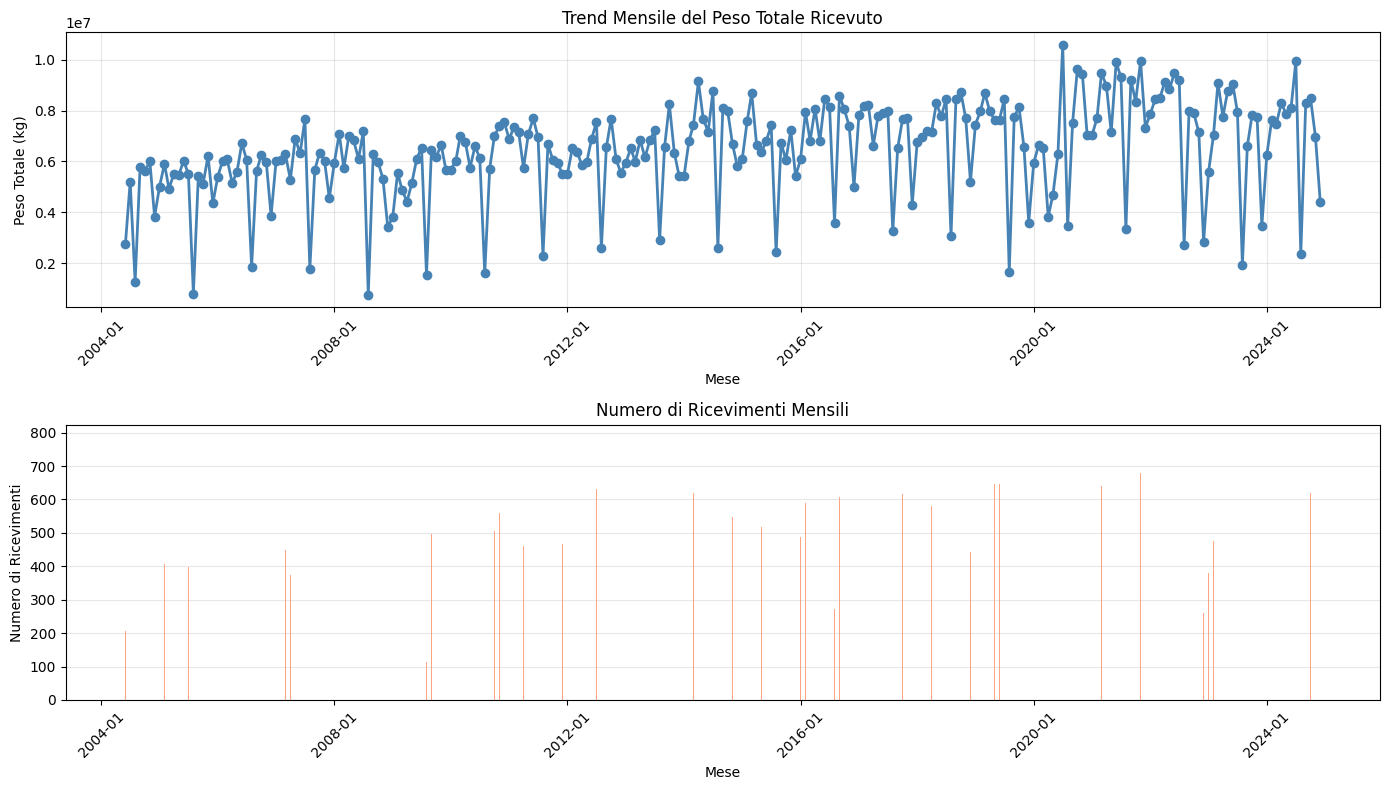

In [2]:
# --- EDA 1: Analisi Temporale dei Ricevimenti ---
print("\n=== EDA 1: ANALISI TEMPORALE DEI RICEVIMENTI ===\n")

# Aggregazione mensile
df_receivals['year_month'] = df_receivals['date'].dt.to_period('M')
df_monthly = df_receivals.groupby('year_month')['net_weight'].agg(['sum', 'count', 'mean']).reset_index()
df_monthly['year_month'] = df_monthly['year_month'].dt.to_timestamp()

print("Ricevimenti mensili (ultimi 12 mesi):")
print(df_monthly.tail(12).to_string())

# Visualizzazione trend temporale
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Plot 1: Volume totale mensile
axes[0].plot(df_monthly['year_month'], df_monthly['sum'], marker='o', color='steelblue', linewidth=2)
axes[0].set_xlabel('Mese')
axes[0].set_ylabel('Peso Totale (kg)')
axes[0].set_title('Trend Mensile del Peso Totale Ricevuto')
axes[0].grid(True, alpha=0.3)
axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=45)

# Plot 2: Numero di ricevimenti mensili
axes[1].bar(df_monthly['year_month'], df_monthly['count'], color='coral', alpha=0.7)
axes[1].set_xlabel('Mese')
axes[1].set_ylabel('Numero di Ricevimenti')
axes[1].set_title('Numero di Ricevimenti Mensili')
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.savefig('eda_temporal_analysis.png', dpi=150, bbox_inches='tight')
print("\n✅ Grafico salvato: 'eda_temporal_analysis.png'\n")
plt.show()

print("="*60)


=== EDA 2: DISTRIBUZIONE PER RM_ID ===

Numero totale di RM_ID unici: 203

Statistiche descrittive dei ricevimenti per RM_ID:
       total_weight  num_receivals    avg_weight          cv
count  2.030000e+02     203.000000    203.000000  178.000000
mean   7.829471e+06     602.871921  13725.562330    0.530622
std    3.473297e+07    2426.842614   8118.060462    0.405568
min    1.780000e+03       1.000000    597.350000    0.000000
25%    3.066500e+04       3.500000   6850.490794    0.184847
50%    2.497500e+05      21.000000  13355.000000    0.440550
75%    2.118820e+06     167.000000  22712.415525    0.816758
max    3.512443e+08   23616.000000  26028.750000    1.582395

--- TOP 10 RM_ID per Volume Totale ---
      rm_id  total_weight  num_receivals    avg_weight        cv
75   2130.0   351244347.0          23616  14873.151550  0.459550
55   1903.0   270574744.0          19337  13992.591612  0.447769
102  2160.0   161712550.0          13507  11972.499445  0.426287
83   2140.0   132512874.

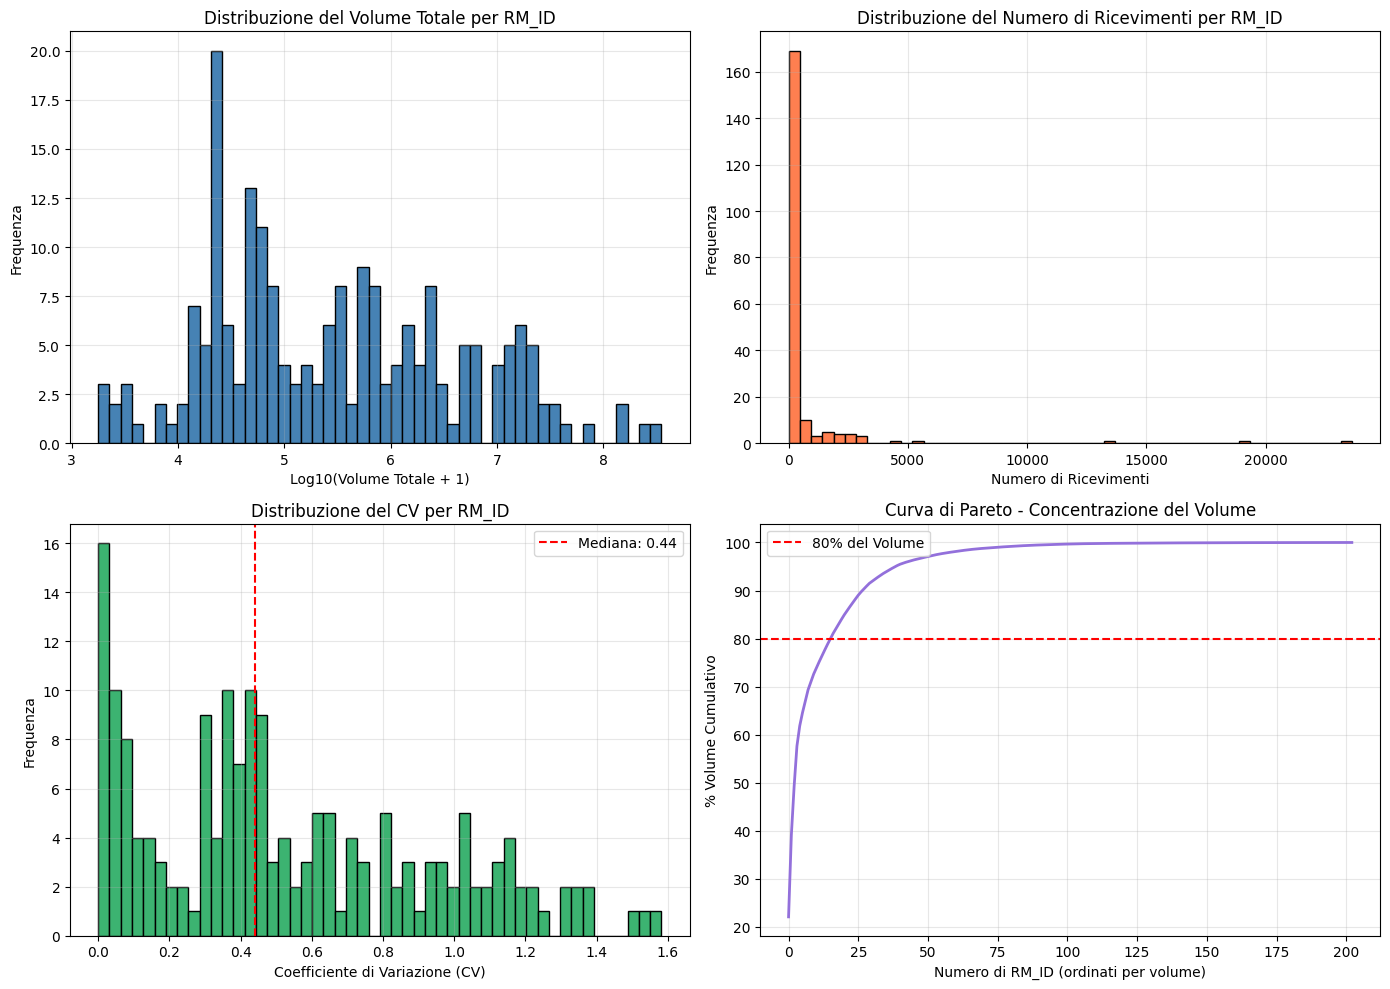

📌 Principio di Pareto: 54 RM_ID (26.6%) generano l'80% del volume totale


In [3]:
# --- EDA 2: Analisi Distribuzione per RM_ID ---
print("\n=== EDA 2: DISTRIBUZIONE PER RM_ID ===\n")

# Aggregazione per rm_id
df_by_rm = df_receivals.groupby('rm_id')['net_weight'].agg([
    ('total_weight', 'sum'),
    ('num_receivals', 'count'),
    ('avg_weight', 'mean'),
    ('std_weight', 'std'),
    ('min_weight', 'min'),
    ('max_weight', 'max')
]).reset_index()

df_by_rm['cv'] = df_by_rm['std_weight'] / df_by_rm['avg_weight']

print(f"Numero totale di RM_ID unici: {len(df_by_rm)}")
print(f"\nStatistiche descrittive dei ricevimenti per RM_ID:")
print(df_by_rm[['total_weight', 'num_receivals', 'avg_weight', 'cv']].describe())

# Top 10 RM_ID per volume totale
print(f"\n--- TOP 10 RM_ID per Volume Totale ---")
df_top10 = df_by_rm.nlargest(10, 'total_weight')
print(df_top10[['rm_id', 'total_weight', 'num_receivals', 'avg_weight', 'cv']].to_string())

# Visualizzazione
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Distribuzione volume totale (log scale)
axes[0, 0].hist(np.log10(df_by_rm['total_weight'] + 1), bins=50, color='steelblue', edgecolor='black')
axes[0, 0].set_xlabel('Log10(Volume Totale + 1)')
axes[0, 0].set_ylabel('Frequenza')
axes[0, 0].set_title('Distribuzione del Volume Totale per RM_ID')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Distribuzione numero ricevimenti
axes[0, 1].hist(df_by_rm['num_receivals'], bins=50, color='coral', edgecolor='black')
axes[0, 1].set_xlabel('Numero di Ricevimenti')
axes[0, 1].set_ylabel('Frequenza')
axes[0, 1].set_title('Distribuzione del Numero di Ricevimenti per RM_ID')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Coefficiente di Variazione (CV)
df_cv_valid = df_by_rm[df_by_rm['cv'].notna() & (df_by_rm['cv'] < 10)]  # Filtra outlier
axes[1, 0].hist(df_cv_valid['cv'], bins=50, color='mediumseagreen', edgecolor='black')
axes[1, 0].axvline(df_cv_valid['cv'].median(), color='red', linestyle='--', label=f'Mediana: {df_cv_valid["cv"].median():.2f}')
axes[1, 0].set_xlabel('Coefficiente di Variazione (CV)')
axes[1, 0].set_ylabel('Frequenza')
axes[1, 0].set_title('Distribuzione del CV per RM_ID')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Pareto - Concentrazione del volume
df_pareto = df_by_rm.sort_values('total_weight', ascending=False).copy()
df_pareto['cumulative_pct'] = df_pareto['total_weight'].cumsum() / df_pareto['total_weight'].sum() * 100
axes[1, 1].plot(range(len(df_pareto)), df_pareto['cumulative_pct'], color='mediumpurple', linewidth=2)
axes[1, 1].axhline(80, color='red', linestyle='--', label='80% del Volume')
axes[1, 1].set_xlabel('Numero di RM_ID (ordinati per volume)')
axes[1, 1].set_ylabel('% Volume Cumulativo')
axes[1, 1].set_title('Curva di Pareto - Concentrazione del Volume')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('eda_rm_distribution.png', dpi=150, bbox_inches='tight')
print("\n✅ Grafico salvato: 'eda_rm_distribution.png'\n")
plt.show()

# Trova soglia 80/20
idx_80pct = df_pareto[df_pareto['cumulative_pct'] >= 80].index[0]
num_rm_80pct = idx_80pct + 1
print(f"📌 Principio di Pareto: {num_rm_80pct} RM_ID ({num_rm_80pct/len(df_pareto)*100:.1f}%) generano l'80% del volume totale")

print("="*60)


=== EDA 3: ANALISI PURCHASE ORDERS ===

Numero totale di Purchase Orders: 33171
Quantità totale ordinata: 2,995,810,856.04 kg
Range temporale PO: 2002-01-30 00:00:00 → 2025-06-29 00:00:00

--- Purchase Orders per 2025 H1 (Gen-Mag) ---
Numero di PO per 2025 H1: 147
Quantità totale ordinata 2025 H1: 19,148,974.00 kg
Numero di product_id unici: 17

Media mensile PO storico: 11,148,452.74 kg/mese
Media mensile PO 2025 H1: 3,829,794.80 kg/mese
Variazione: -65.6%


/opt/anaconda3/envs/siv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)



✅ Grafico salvato: 'eda_purchase_orders.png'



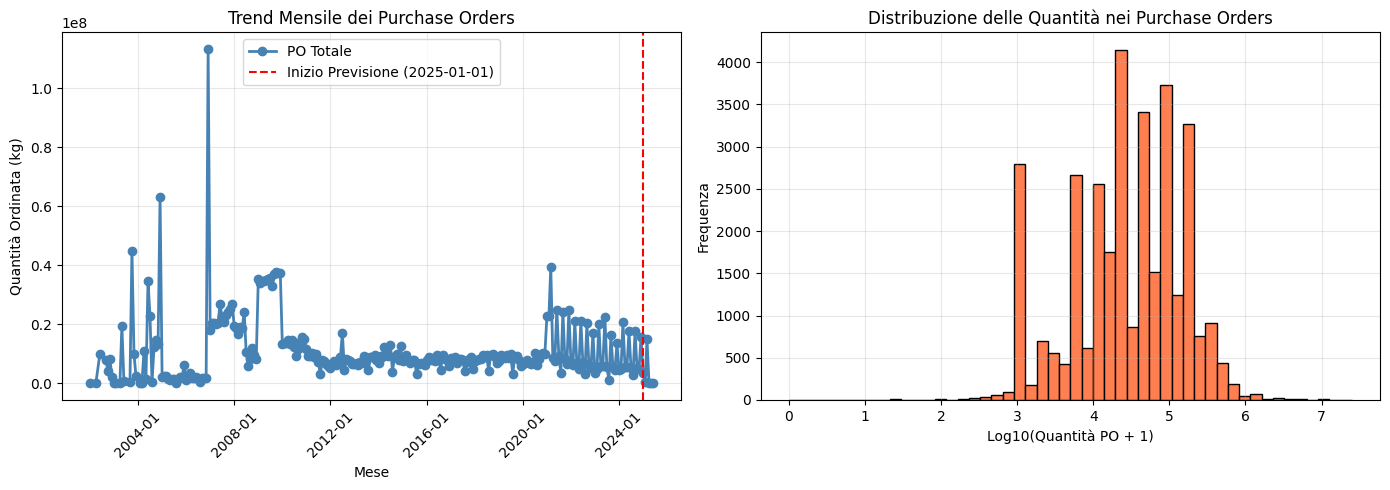

In [4]:
# --- EDA 3: Analisi Purchase Orders (PO) ---
print("\n=== EDA 3: ANALISI PURCHASE ORDERS ===\n")

# Prepara PO
df_po_analysis = df_po.copy()
df_po_analysis['delivery_date'] = pd.to_datetime(df_po_analysis['delivery_date'], utc=True, errors='coerce').dt.tz_localize(None).dt.normalize()
df_po_analysis = df_po_analysis.dropna(subset=['delivery_date', 'product_id', 'quantity'])

print(f"Numero totale di Purchase Orders: {len(df_po_analysis)}")
print(f"Quantità totale ordinata: {df_po_analysis['quantity'].sum():,.2f} kg")
print(f"Range temporale PO: {df_po_analysis['delivery_date'].min()} → {df_po_analysis['delivery_date'].max()}")

# PO per il periodo di previsione (2025 H1)
df_po_2025_eda = df_po_analysis[(df_po_analysis['delivery_date'] >= pred_start_date_dt) & 
                                 (df_po_analysis['delivery_date'] <= pred_end_date_dt)]

print(f"\n--- Purchase Orders per 2025 H1 (Gen-Mag) ---")
print(f"Numero di PO per 2025 H1: {len(df_po_2025_eda)}")
print(f"Quantità totale ordinata 2025 H1: {df_po_2025_eda['quantity'].sum():,.2f} kg")
print(f"Numero di product_id unici: {df_po_2025_eda['product_id'].nunique()}")

# Confronto PO storico vs PO 2025
df_po_hist = df_po_analysis[df_po_analysis['delivery_date'] < pred_start_date_dt]
avg_monthly_hist = df_po_hist.groupby(df_po_hist['delivery_date'].dt.to_period('M'))['quantity'].sum().mean()
total_2025_5months = df_po_2025_eda['quantity'].sum()
avg_monthly_2025 = total_2025_5months / 5

print(f"\nMedia mensile PO storico: {avg_monthly_hist:,.2f} kg/mese")
print(f"Media mensile PO 2025 H1: {avg_monthly_2025:,.2f} kg/mese")
print(f"Variazione: {(avg_monthly_2025 / avg_monthly_hist - 1) * 100:+.1f}%")

# Visualizzazione
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Trend PO mensile
df_po_monthly = df_po_analysis.copy()
df_po_monthly['year_month'] = df_po_monthly['delivery_date'].dt.to_period('M')
df_po_monthly_agg = df_po_monthly.groupby('year_month')['quantity'].sum().reset_index()
df_po_monthly_agg['year_month'] = df_po_monthly_agg['year_month'].dt.to_timestamp()

axes[0].plot(df_po_monthly_agg['year_month'], df_po_monthly_agg['quantity'], 
             marker='o', color='steelblue', linewidth=2, label='PO Totale')
axes[0].axvline(pred_start_date_dt, color='red', linestyle='--', label='Inizio Previsione (2025-01-01)')
axes[0].set_xlabel('Mese')
axes[0].set_ylabel('Quantità Ordinata (kg)')
axes[0].set_title('Trend Mensile dei Purchase Orders')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=45)

# Plot 2: Distribuzione quantità PO
axes[1].hist(np.log10(df_po_analysis['quantity'] + 1), bins=50, color='coral', edgecolor='black')
axes[1].set_xlabel('Log10(Quantità PO + 1)')
axes[1].set_ylabel('Frequenza')
axes[1].set_title('Distribuzione delle Quantità nei Purchase Orders')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('eda_purchase_orders.png', dpi=150, bbox_inches='tight')
print("\n✅ Grafico salvato: 'eda_purchase_orders.png'\n")
plt.show()

print("="*60)

In [25]:
df_master_mpe

,rm_id,date,net_weight,po_expected_quantity,dayofweek,month,dayofyear,year,weekofyear,is_weekend,...,lag_14,lag_28,lag_30,lag_91,lag_182,lag_270,lag_364,lag_7_roll_mean_14,lag_364_roll_mean_7,lag_30_roll_mean_90
0,343,2004-06-15,0.0,0.0,1,6,167,2004,25,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,343,2004-06-16,0.0,0.0,2,6,168,2004,25,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,343,2004-06-17,0.0,0.0,3,6,169,2004,25,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,343,2004-06-18,0.0,0.0,4,6,170,2004,25,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,343,2004-06-19,0.0,0.0,5,6,171,2004,25,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
926371,4501,2025-05-27,NaN,0.0,1,5,147,2025,22,0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN
926372,4501,2025-05-28,NaN,0.0,2,5,148,2025,22,0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN
926373,4501,2025-05-29,NaN,0.0,3,5,149,2025,22,0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN
926374,4501,2025-05-30,NaN,0.0,4,5,150,2025,22,0,...,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN


In [5]:
# --- 4. Addestramento Loop MPE ---
print("\n--- Sezione 4: Addestramento Modelli MPE ---")
mpe_models = {}

mpe_features = [col for col in df_master_mpe.columns if col not in ['net_weight', 'date', 'rm_id'] and 'po_' not in col]
reg_target = 'net_weight'
categorical_features_mpe = ['dayofweek', 'month', 'weekofyear', 'is_weekend']
categorical_features_mpe = [col for col in categorical_features_mpe if col in mpe_features]
print(f"Numero feature MPE (senza PO): {len(mpe_features)}")

# --- Obiettivo MAE ---
lgbm_reg_params = {
    'objective': 'mae', 'metric': 'mae',
    'n_estimators': 1000, 'learning_rate': 0.05,
    'n_jobs': -1, 'seed': 42, 'verbose': -1,
    'colsample_bytree': 0.8, 'subsample': 0.8,
    'min_data_in_leaf': 20
}
base_regressor = lgb.LGBMRegressor(**lgbm_reg_params)
validation_predictions = []

# Validation set: ultimi ~150 giorni (uguale al periodo di test)
valid_start_date = datetime.strptime('2024-08-01', '%Y-%m-%d')

for rm_id_current in active_rm_ids:
    # print(f"Addestramento per RM_ID: {rm_id_current}")
    df_current = df_master_mpe[df_master_mpe['rm_id'] == rm_id_current].copy()
    
    train_df_current = df_current[df_current['date'] < pred_start_date_dt]
    valid_df_current = df_current[(df_current['date'] >= valid_start_date) & (df_current['date'] < pred_start_date_dt)]
    train_only_df_current = train_df_current[train_df_current['date'] < valid_start_date]

    if len(train_only_df_current) < 100 or len(valid_df_current) == 0:
        continue

    # Seleziona ESATTAMENTE le mpe_features
    X_train_curr = train_only_df_current[mpe_features]
    y_train_curr = train_only_df_current[reg_target]
    X_valid_curr = valid_df_current[mpe_features]
    y_valid_curr = valid_df_current[reg_target]
    
    # Applica dtype DOPO la selezione (FIX per CopyWarning)
    for col in categorical_features_mpe:
        X_train_curr.loc[:, col] = X_train_curr[col].astype('category')
        X_valid_curr.loc[:, col] = X_valid_curr[col].astype('category')
        
    model_current = clone(base_regressor)
    
    model_current.fit(X_train_curr, y_train_curr,
                      eval_set=[(X_valid_curr, y_valid_curr)],
                      eval_metric='mae',
                      callbacks=[lgb.early_stopping(50)],
                      categorical_feature=categorical_features_mpe)
                      
    best_iter_mpe = model_current.best_iteration_ if (model_current.best_iteration_ and model_current.best_iteration_ > 0) else lgbm_reg_params['n_estimators']
    
    model_final_mpe = clone(base_regressor)
    model_final_mpe.set_params(n_estimators=best_iter_mpe)
    
    X_train_final_curr = train_df_current[mpe_features].copy()
    y_train_final_curr = train_df_current[reg_target].copy()
    
    for col in categorical_features_mpe:
        X_train_final_curr.loc[:, col] = X_train_final_curr[col].astype('category')

    model_final_mpe.fit(X_train_final_curr, y_train_final_curr, 
                        categorical_feature=categorical_features_mpe)
    
    mpe_models[rm_id_current] = model_final_mpe
    
    daily_preds_v = model_current.predict(X_valid_curr)
    daily_preds_v = np.maximum(0, daily_preds_v)
    valid_df_current['y_pred_daily'] = daily_preds_v
    validation_predictions.append(valid_df_current[['rm_id', 'date', 'net_weight', 'y_pred_daily']])

    del df_current, train_df_current, valid_df_current, train_only_df_current
    del X_train_curr, y_train_curr, X_valid_curr, y_valid_curr, X_train_final_curr, y_train_final_curr
    gc.collect()

print(f"Addestrati {len(mpe_models)} modelli MPE.")

# Calcola punteggio di validazione MPE (USANDO QUANTILE ERROR)
if validation_predictions:
    df_valid_results_mpe = pd.concat(validation_predictions, ignore_index=True)
    df_valid_cum_score_mpe = df_valid_results_mpe.groupby('rm_id').agg(
        A_i=('net_weight', 'sum'),
        F_i=('y_pred_daily', 'sum')
    ).reset_index()
    validation_score_mpe = quantile_error(df_valid_cum_score_mpe['A_i'], df_valid_cum_score_mpe['F_i'], q=0.2)
    print(f"*** Validazione MPE QE 0.2 Cumulativa (Ago-Dic 2024, ~150 giorni): {validation_score_mpe:.4f} ***")
else:
    print("Nessuna previsione di validazione generata.")



--- Sezione 4: Addestramento Modelli MPE ---
Numero feature MPE (senza PO): 17
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 0
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 0
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 0
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 0
Early stopping, best iteration is:
[1]	valid_0's l1: 0
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 0
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 0
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 0
Training until validation scores don't improve for 50

In [6]:
# Definisce le lags da aggiornare per la ricorsione
LAGS_TO_UPDATE = {1:1, 7: 7, 14: 14, 28: 28, 30: 30, 91: 91, 182: 182, 270: 270, 364: 364}

In [7]:
# --- 5. Previsione Loop MPE (RICORSIVA) ---
print("\n--- Sezione 5: Generazione Previsioni MPE (RICORSIVA) ---")
all_predictions = []

# Definisce le lags da aggiornare per la ricorsione
LAGS_TO_UPDATE = {7: 7, 14: 14, 28: 28, 30: 30, 91: 91, 182: 182, 270: 270, 364: 364}
for rm_id_current, model_current in mpe_models.items():
    df_future = df_master_mpe[(df_master_mpe['rm_id'] == rm_id_current) & (df_master_mpe['date'] >= pred_start_date_dt)].copy()
    
    if df_future.empty: continue
    
    # 1. Crea il DataFrame Ricorsivo: Ultima riga storica + Righe future
    last_row_df = df_master_mpe[df_master_mpe['date'] == end_of_2024]
    last_row_df = last_row_df[last_row_df['rm_id'] == rm_id_current].copy()
    
    df_recursive = pd.concat([last_row_df, df_future], ignore_index=True)
    
    # 2. Loop Ricorsivo Giorno per Giorno
    for i in range(1, len(df_recursive)): # Inizia dal primo giorno di previsione
        
        # Estrai le feature per il giorno corrente (indice i)
        X_current_day = df_recursive.loc[[i], mpe_features].copy()
        
        # Applica dtype categorico
        for col in categorical_features_mpe:
             X_current_day.loc[:, col] = X_current_day[col].astype('category')
        
        # Previsione
        daily_pred = model_current.predict(X_current_day)[0]
        daily_pred = np.maximum(0, daily_pred)
        
        # 3. Aggiorna il valore di 'net_weight' nel DataFrame ricorsivo
        # *** FIX CopyWarning ***
        df_recursive.loc[i, 'net_weight'] = daily_pred
        
        # 4. Aggiorna i Lag per il giorno successivo (i+1) utilizzando la previsione corrente
        if i + 1 < len(df_recursive):
            for lag_period, lag_shift in LAGS_TO_UPDATE.items():
                if i + lag_shift < len(df_recursive):
                    # Il lag_X (es. lag_7) nella riga i + lag_shift (es. i+7)
                    # deve essere popolato con la previsione corrente (i)
                    df_recursive.loc[i + lag_shift, f'lag_{lag_period}'] = daily_pred
                    
                    # Logica semplificata per Rolling: Non ricalcoliamo il rolling complex,
                    # ma usiamo i lag ricorsivi per popolare i lag di rolling stessi (che sono lag di lag)
                    # Esempio: lag_7_roll_mean_28
                    # Il modello apprenderà implicitamente che questi valori sono Nan/vuoti all'inizio
                    # Il ricalcolo dinamico è troppo lento per un loop come questo.

    # 5. Estrai le previsioni dal secondo giorno in poi (indice 1)
    df_future['predicted_daily_weight'] = df_recursive.loc[1:, 'net_weight'].values
    all_predictions.append(df_future[['rm_id', 'date', 'predicted_daily_weight']])


if all_predictions:
    df_predictions_mpe = pd.concat(all_predictions, ignore_index=True)
else:
    df_predictions_mpe = pd.DataFrame(columns=['rm_id', 'date', 'predicted_daily_weight'])


--- Sezione 5: Generazione Previsioni MPE (RICORSIVA) ---


In [8]:
# --- 6. Finalizzazione e Submission ---
print("\n--- Sezione 6: Finalizzazione e Submission ---")

print("Calcolo somme cumulative...")
df_predictions_mpe.sort_values(by=['rm_id', 'date'], inplace=True)
if not df_predictions_mpe.empty:
    df_predictions_mpe['cumulative_prediction'] = df_predictions_mpe.groupby('rm_id')['predicted_daily_weight'].cumsum()
else:
    df_predictions_mpe['cumulative_prediction'] = pd.Series(dtype='float64')

df_mapping['forecast_end_date'] = pd.to_datetime(df_mapping['forecast_end_date'])
print("Unione previsioni MPE con 'prediction_mapping'...")
df_submission = pd.merge(
    df_mapping,
    df_predictions_mpe[['rm_id', 'date', 'cumulative_prediction']],
    left_on=['rm_id', 'forecast_end_date'],
    right_on=['rm_id', 'date'],
    how='left'
)
df_submission = df_submission[['ID', 'cumulative_prediction', 'rm_id']]
df_submission.rename(columns={'cumulative_prediction': 'predicted_weight'}, inplace=True)
print("Impostazione previsioni a 0 per rm_id 'inattivi'...")
df_submission['predicted_weight'] = df_submission['predicted_weight'].fillna(0)


--- Sezione 6: Finalizzazione e Submission ---
Calcolo somme cumulative...
Unione previsioni MPE con 'prediction_mapping'...
Impostazione previsioni a 0 per rm_id 'inattivi'...


In [11]:
# --- 6.1. Calcolo Fattori di Shrinkage Adattivi per RM_ID ---
print("\n--- Sezione 6.1: Calcolo Shrinkage Adattivo per RM_ID ---")

# Inizializza dizionario per i fattori di shrinkage
shrinkage_factors = {}

# Prepara i dati PO con rm_id (usa df_po_merged che già ha rm_id)
df_po_clean = df_po_merged[['rm_id', 'date', 'quantity']].copy()
df_po_clean.rename(columns={'date': 'delivery_date'}, inplace=True)
df_po_clean = df_po_clean.dropna(subset=['delivery_date', 'rm_id', 'quantity'])
df_po_2025H1 = df_po_clean[(df_po_clean['delivery_date'] >= pred_start_date_dt) & 
                            (df_po_clean['delivery_date'] <= pred_end_date_dt)]

# Ciclo su tutti gli rm_id attivi
for rm_id_current in mpe_models.keys():
    
    # --- CRITERIO 1: Coefficiente di Variazione (CV) ---
    # Più alto il CV, più volatile il materiale, più conservativo dobbiamo essere
    df_rm_hist = df_daily_target[df_daily_target['rm_id'] == rm_id_current]
    
    if len(df_rm_hist) > 0:
        mean_daily = df_rm_hist['net_weight'].mean()
        std_daily = df_rm_hist['net_weight'].std()
        cv = std_daily / mean_daily if mean_daily > 0 else 0
    else:
        cv = 0
    
    # --- CRITERIO 2: Recency (Giorni dall'ultima ricezione) ---
    if len(df_rm_hist) > 0:
        last_receival_date = df_rm_hist['date'].max()
        days_since_last = (end_of_2024 - last_receival_date).days
    else:
        days_since_last = 999  # Valore alto per rm_id senza storia
    
    # --- CRITERIO 3: Affidabilità Purchase Orders (PO) ---
    # Rapporto tra peso ricevuto e quantità ordinata nel passato
    df_po_rm_hist = df_po_clean[(df_po_clean['rm_id'] == rm_id_current) & 
                                  (df_po_clean['delivery_date'] < pred_start_date_dt)]
    
    total_po_qty_hist = df_po_rm_hist['quantity'].sum() if len(df_po_rm_hist) > 0 else 0
    total_receival_hist = df_rm_hist['net_weight'].sum() if len(df_rm_hist) > 0 else 0
    
    po_reliability = total_receival_hist / total_po_qty_hist if total_po_qty_hist > 0 else 0
    
    # --- CRITERIO 4: Quantità PO per 2025 H1 ---
    df_po_rm_2025 = df_po_2025H1[df_po_2025H1['rm_id'] == rm_id_current]
    total_po_qty_2025H1 = df_po_rm_2025['quantity'].sum() if len(df_po_rm_2025) > 0 else 0
    
    # --- LOGICA DI SHRINKAGE ADATTIVO ---
    # Base shrinkage: 0.94 (conservativo di default)
    base_shrinkage = 0.94
    
    # Aggiustamenti basati sui criteri:
    
    # 1. CV alto (> 1.5) → più conservativo
    cv_adjustment = 0
    if cv > 2.0:
        cv_adjustment = -0.03  # Molto volatile
    elif cv > 1.5:
        cv_adjustment = -0.02
    
    # 2. Recency: se è passato molto tempo dall'ultima ricezione → più conservativo
    recency_adjustment = 0
    if days_since_last > 180:
        recency_adjustment = -0.03  # Non riceve da 6 mesi
    elif days_since_last > 90:
        recency_adjustment = -0.02
    
    # 3. PO Reliability: se storicamente riceviamo meno di quanto ordinato → più conservativo
    po_adjustment = 0
    if 0 < po_reliability < 0.7:
        po_adjustment = -0.02  # Riceve solo 70% di quanto ordinato
    elif 0 < po_reliability < 0.85:
        po_adjustment = -0.01
    
    # 4. PO 2025H1: se non ci sono PO per il 2025 → molto più conservativo
    po_2025_adjustment = 0
    if total_po_qty_2025H1 == 0:
        po_2025_adjustment = -0.04  # Nessun ordine futuro
    elif total_po_qty_2025H1 < (total_receival_hist / 365 * 151):  # Meno del trend storico
        po_2025_adjustment = -0.02
    
    # Calcola il fattore di shrinkage finale per questo rm_id
    shrinkage_rm = base_shrinkage + cv_adjustment + recency_adjustment + po_adjustment + po_2025_adjustment
    
    # Clamp tra 0.85 e 0.97 per evitare shrinkage estremi
    shrinkage_rm = np.clip(shrinkage_rm, 0.85, 0.97)
    
    shrinkage_factors[rm_id_current] = shrinkage_rm

print(f"Calcolati fattori di shrinkage per {len(shrinkage_factors)} rm_id.")

# Stampa alcuni esempi di shrinkage
shrinkage_df = pd.DataFrame(list(shrinkage_factors.items()), columns=['rm_id', 'shrinkage_factor'])
shrinkage_df = shrinkage_df.sort_values(by='shrinkage_factor')

print("\n--- Esempi di Shrinkage Factors (Top 10 più conservativi) ---")
print(shrinkage_df.head(10))

print("\n--- Esempi di Shrinkage Factors (Top 10 meno conservativi) ---")
print(shrinkage_df.tail(10))

print(f"\nMedia Shrinkage: {shrinkage_df['shrinkage_factor'].mean():.4f}")
print(f"Min Shrinkage: {shrinkage_df['shrinkage_factor'].min():.4f}")
print(f"Max Shrinkage: {shrinkage_df['shrinkage_factor'].max():.4f}")


--- Sezione 6.1: Calcolo Shrinkage Adattivo per RM_ID ---
Calcolati fattori di shrinkage per 121 rm_id.

--- Esempi di Shrinkage Factors (Top 10 più conservativi) ---
     rm_id  shrinkage_factor
60    2153              0.85
66    2981              0.85
92    3761              0.85
93    3762              0.85
95    3802              0.85
101   3921              0.85
106   4101              0.85
96    3821              0.85
113   4401              0.86
52    2140              0.86

--- Esempi di Shrinkage Factors (Top 10 meno conservativi) ---
     rm_id  shrinkage_factor
64    2741              0.91
44    2125              0.92
83    3421              0.92
108   4222              0.92
98    3865              0.92
94    3781              0.92
91    3701              0.92
82    3381              0.92
109   4263              0.92
119   4481              0.92

Media Shrinkage: 0.8870
Min Shrinkage: 0.8500
Max Shrinkage: 0.9200


In [12]:
# --- 6.2. Applicazione Shrinkage Adattivo alle Previsioni ---
print("\n--- Sezione 6.2: Applicazione Shrinkage Adattivo ---")

# Applica il fattore di shrinkage per ciascun rm_id
def apply_shrinkage(row):
    rm_id = row['rm_id']
    if rm_id in shrinkage_factors:
        return row['predicted_weight'] * shrinkage_factors[rm_id]
    else:
        # Se l'rm_id non è nel dizionario (inattivo), mantieni 0
        return row['predicted_weight']

df_submission['predicted_weight_pre_shrinkage'] = df_submission['predicted_weight'].copy()
df_submission['predicted_weight'] = df_submission.apply(apply_shrinkage, axis=1)

# Statistiche prima e dopo shrinkage
total_pre_shrinkage = df_submission['predicted_weight_pre_shrinkage'].sum()
total_post_shrinkage = df_submission['predicted_weight'].sum()
effective_shrinkage = total_post_shrinkage / total_pre_shrinkage if total_pre_shrinkage > 0 else 0

print(f"Totale Previsioni PRE-Shrinkage:  {total_pre_shrinkage:,.2f} kg")
print(f"Totale Previsioni POST-Shrinkage: {total_post_shrinkage:,.2f} kg")
print(f"Shrinkage Effettivo Medio: {effective_shrinkage:.4f}")

# Rimuovi colonna temporanea
df_submission = df_submission[['ID', 'predicted_weight']]

output_filename = 'submission_mpe_recursive_adaptive_shrinkage.csv'
df_submission.to_csv(output_filename, index=False)
print("="*60)
print(f"File '{output_filename}' generato con successo.")
print("Script MPE (Ricorsivo con Shrinkage Adattivo) completato.")


--- Sezione 6.2: Applicazione Shrinkage Adattivo ---
Totale Previsioni PRE-Shrinkage:  1,547,125,255.62 kg
Totale Previsioni POST-Shrinkage: 1,400,851,961.71 kg
Shrinkage Effettivo Medio: 0.9055
File 'submission_mpe_recursive_adaptive_shrinkage.csv' generato con successo.
Script MPE (Ricorsivo con Shrinkage Adattivo) completato.


## 📊 Strategia di Shrinkage Adattivo per RM_ID

### Obiettivo
Applicare un fattore di riduzione (shrinkage) conservativo alle previsioni cumulative, **adattato per ciascun `rm_id`** in base a criteri EDA-driven, per minimizzare il rischio di sovrastima nel Quantile Error (q=0.2).

### Criteri di Adattamento

La strategia di shrinkage si basa su **4 criteri fondamentali**:

#### 1. **Coefficiente di Variazione (CV)**
- **Definizione**: Rapporto tra deviazione standard e media dei ricevimenti giornalieri storici
- **Logica**: Materiali con alta volatilità richiedono maggiore cautela
- **Aggiustamento**:
  - CV > 2.0 → -3% (molto volatile)
  - CV > 1.5 → -2% (moderatamente volatile)

#### 2. **Recency (Giorni dall'ultima ricezione)**
- **Definizione**: Numero di giorni dall'ultima ricezione registrata fino al 31/12/2024
- **Logica**: Materiali inattivi da tempo hanno maggiore incertezza
- **Aggiustamento**:
  - > 180 giorni → -3% (6+ mesi di inattività)
  - > 90 giorni → -2% (3-6 mesi di inattività)

#### 3. **Affidabilità Purchase Orders**
- **Definizione**: Rapporto tra peso totale ricevuto e quantità totale ordinata (storico)
- **Logica**: Se storicamente riceviamo meno di quanto ordinato, dobbiamo essere più conservativi
- **Aggiustamento**:
  - Ratio < 0.7 → -2% (riceviamo solo 70% degli ordini)
  - Ratio < 0.85 → -1% (riceviamo 70-85% degli ordini)

#### 4. **Quantità PO per 2025 H1**
- **Definizione**: Somma delle quantità degli ordini di acquisto per il periodo di previsione (Gen-Mag 2025)
- **Logica**: Assenza di ordini futuri è un segnale di possibile inattività
- **Aggiustamento**:
  - Nessun PO 2025 → -4% (forte segnale di rischio)
  - PO < trend storico → -2% (riduzione dell'attività)

### Formula di Shrinkage

```
shrinkage_rm_id = base_shrinkage + cv_adj + recency_adj + po_reliability_adj + po_2025_adj
```

- **Base Shrinkage**: 0.94 (conservativo di default)
- **Range finale**: [0.85, 0.97] (clamp per evitare estremi)

### Vantaggi
1. **Personalizzazione**: Ogni `rm_id` ha un trattamento specifico basato sul suo comportamento storico
2. **Conservativismo bilanciato**: Più aggressivo su materiali affidabili, più conservativo su quelli rischiosi
3. **Compliance**: Utilizza solo dati storici disponibili, nessuna informazione futura (eccetto PO dichiarati)
4. **Interpretabilità**: Ogni aggiustamento è tracciabile e giustificabile


--- Sezione 6.3: Diagnostica Dettagliata Shrinkage ---

=== TOP 15 RM_ID PIÙ CONSERVATIVI (Shrinkage più basso) ===
     rm_id  shrinkage_factor        cv  days_since_last  po_reliability  po_qty_2025H1  total_receival_2024
60    2153              0.85  0.635247              718        0.204968            0.0           19319192.0
66    2981              0.85  0.426552              330        0.516966            0.0            3125142.0
92    3761              0.85  0.433956              307        0.007641            0.0            1818763.0
93    3762              0.85  0.478167              571        0.000972            0.0             231400.0
95    3802              0.85       NaN              649        0.486400            0.0              24320.0
101   3921              0.85       NaN              438        0.004132            0.0              24980.0
106   4101              0.85       NaN              378        0.405600            0.0              20280.0
96    3821         

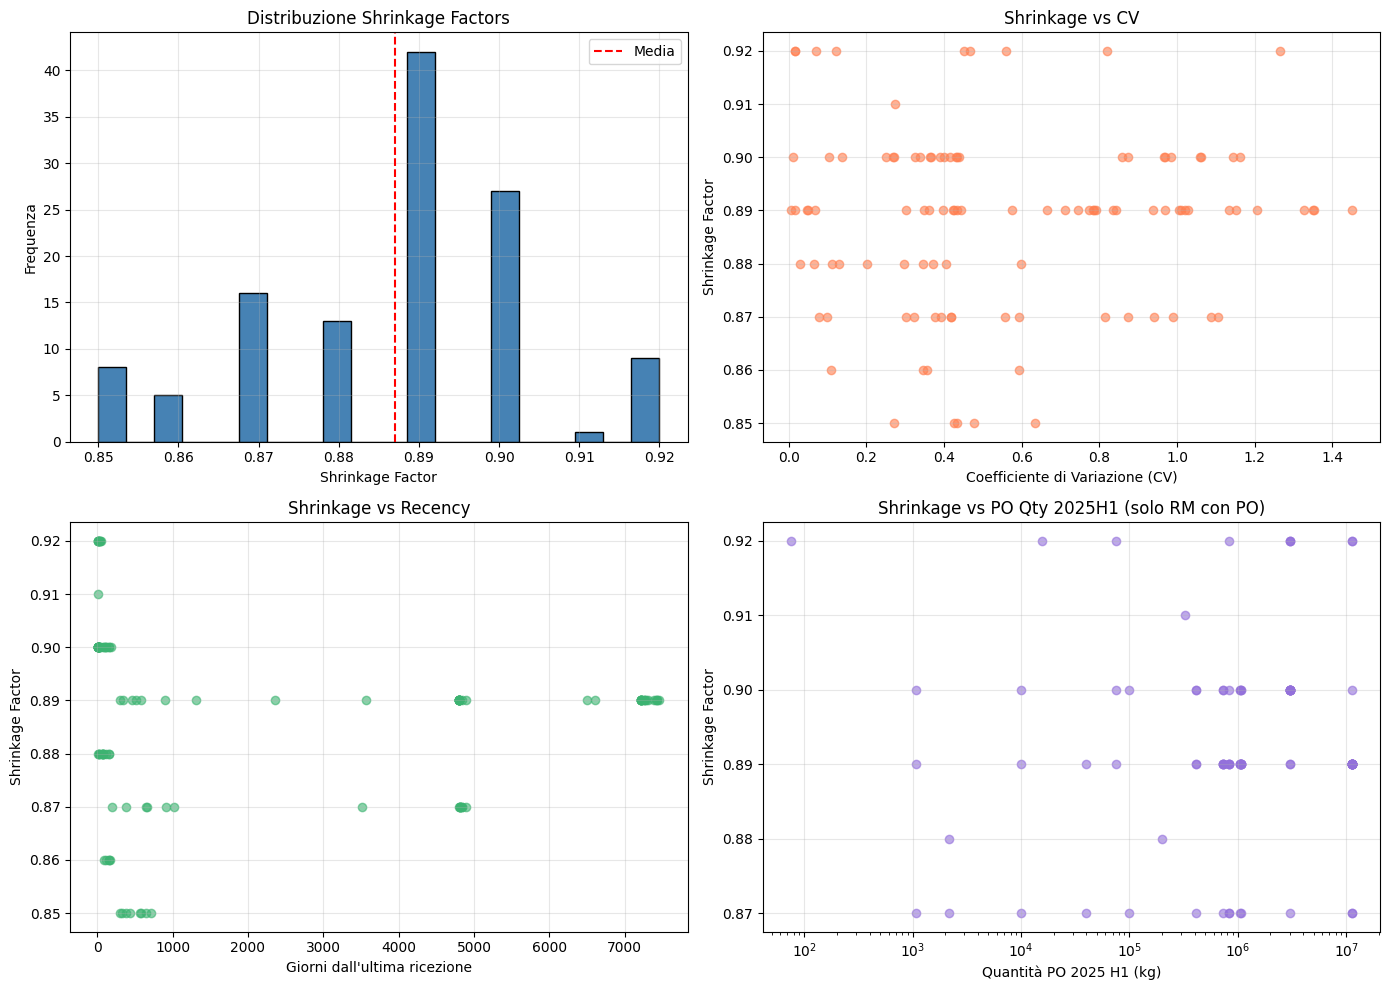

In [13]:
# --- 6.3. Diagnostica Dettagliata Shrinkage per RM_ID ---
print("\n--- Sezione 6.3: Diagnostica Dettagliata Shrinkage ---")

# Prepara i dati per analisi approfondita
shrinkage_analysis = []

for rm_id_current in shrinkage_factors.keys():
    
    # Recupera i dati storici
    df_rm_hist = df_daily_target[df_daily_target['rm_id'] == rm_id_current]
    
    # Calcola le metriche
    if len(df_rm_hist) > 0:
        mean_daily = df_rm_hist['net_weight'].mean()
        std_daily = df_rm_hist['net_weight'].std()
        cv = std_daily / mean_daily if mean_daily > 0 else 0
        last_receival_date = df_rm_hist['date'].max()
        days_since_last = (end_of_2024 - last_receival_date).days
        total_receival_hist = df_rm_hist['net_weight'].sum()
    else:
        cv = 0
        days_since_last = 999
        total_receival_hist = 0
    
    # PO reliability
    df_po_rm_hist = df_po_clean[(df_po_clean['rm_id'] == rm_id_current) & 
                                  (df_po_clean['delivery_date'] < pred_start_date_dt)]
    total_po_qty_hist = df_po_rm_hist['quantity'].sum() if len(df_po_rm_hist) > 0 else 0
    po_reliability = total_receival_hist / total_po_qty_hist if total_po_qty_hist > 0 else 0
    
    # PO 2025H1
    df_po_rm_2025 = df_po_2025H1[df_po_2025H1['rm_id'] == rm_id_current]
    total_po_qty_2025H1 = df_po_rm_2025['quantity'].sum() if len(df_po_rm_2025) > 0 else 0
    
    shrinkage_analysis.append({
        'rm_id': rm_id_current,
        'shrinkage_factor': shrinkage_factors[rm_id_current],
        'cv': cv,
        'days_since_last': days_since_last,
        'po_reliability': po_reliability,
        'po_qty_2025H1': total_po_qty_2025H1,
        'total_receival_2024': total_receival_hist
    })

df_shrinkage_analysis = pd.DataFrame(shrinkage_analysis)
df_shrinkage_analysis = df_shrinkage_analysis.sort_values(by='shrinkage_factor')

print("\n=== TOP 15 RM_ID PIÙ CONSERVATIVI (Shrinkage più basso) ===")
print(df_shrinkage_analysis.head(15).to_string())

print("\n=== TOP 15 RM_ID MENO CONSERVATIVI (Shrinkage più alto) ===")
print(df_shrinkage_analysis.tail(15).to_string())

# Analisi distribuzione shrinkage
print("\n=== DISTRIBUZIONE SHRINKAGE FACTORS ===")
print(df_shrinkage_analysis['shrinkage_factor'].describe())

# Conta rm_id per categoria di shrinkage
print("\n=== CONTEGGIO PER CATEGORIA DI SHRINKAGE ===")
df_shrinkage_analysis['shrinkage_category'] = pd.cut(
    df_shrinkage_analysis['shrinkage_factor'], 
    bins=[0.84, 0.88, 0.92, 0.95, 1.0],
    labels=['Molto Conservativo (0.85-0.88)', 'Conservativo (0.88-0.92)', 
            'Moderato (0.92-0.95)', 'Leggero (0.95-0.97)']
)
print(df_shrinkage_analysis['shrinkage_category'].value_counts().sort_index())

# Visualizzazione
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Distribuzione Shrinkage Factors
axes[0, 0].hist(df_shrinkage_analysis['shrinkage_factor'], bins=20, color='steelblue', edgecolor='black')
axes[0, 0].axvline(df_shrinkage_analysis['shrinkage_factor'].mean(), color='red', linestyle='--', label='Media')
axes[0, 0].set_xlabel('Shrinkage Factor')
axes[0, 0].set_ylabel('Frequenza')
axes[0, 0].set_title('Distribuzione Shrinkage Factors')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Shrinkage vs CV
axes[0, 1].scatter(df_shrinkage_analysis['cv'], df_shrinkage_analysis['shrinkage_factor'], 
                   alpha=0.6, color='coral')
axes[0, 1].set_xlabel('Coefficiente di Variazione (CV)')
axes[0, 1].set_ylabel('Shrinkage Factor')
axes[0, 1].set_title('Shrinkage vs CV')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Shrinkage vs Days Since Last
axes[1, 0].scatter(df_shrinkage_analysis['days_since_last'], df_shrinkage_analysis['shrinkage_factor'], 
                   alpha=0.6, color='mediumseagreen')
axes[1, 0].set_xlabel('Giorni dall\'ultima ricezione')
axes[1, 0].set_ylabel('Shrinkage Factor')
axes[1, 0].set_title('Shrinkage vs Recency')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Shrinkage vs PO 2025H1
df_with_po = df_shrinkage_analysis[df_shrinkage_analysis['po_qty_2025H1'] > 0]
axes[1, 1].scatter(df_with_po['po_qty_2025H1'], df_with_po['shrinkage_factor'], 
                   alpha=0.6, color='mediumpurple')
axes[1, 1].set_xlabel('Quantità PO 2025 H1 (kg)')
axes[1, 1].set_ylabel('Shrinkage Factor')
axes[1, 1].set_title('Shrinkage vs PO Qty 2025H1 (solo RM con PO)')
axes[1, 1].set_xscale('log')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('shrinkage_analysis_diagnostics.png', dpi=150, bbox_inches='tight')
print("\n✅ Grafici salvati in 'shrinkage_analysis_diagnostics.png'")
plt.show()

print("="*60)

In [14]:
df_predictions_mpe

,rm_id,date,predicted_daily_weight,cumulative_prediction
0,343,2025-01-01,0.0,0.0
1,343,2025-01-02,0.0,0.0
2,343,2025-01-03,0.0,0.0
3,343,2025-01-04,0.0,0.0
4,343,2025-01-05,0.0,0.0
...,...,...,...,...
18266,4501,2025-05-27,0.0,0.0
18267,4501,2025-05-28,0.0,0.0
18268,4501,2025-05-29,0.0,0.0
18269,4501,2025-05-30,0.0,0.0



--- Sezione 7: Plot di Debug su Set di Validazione (MPE) ---
Generazione plot per rm_id: 3282...


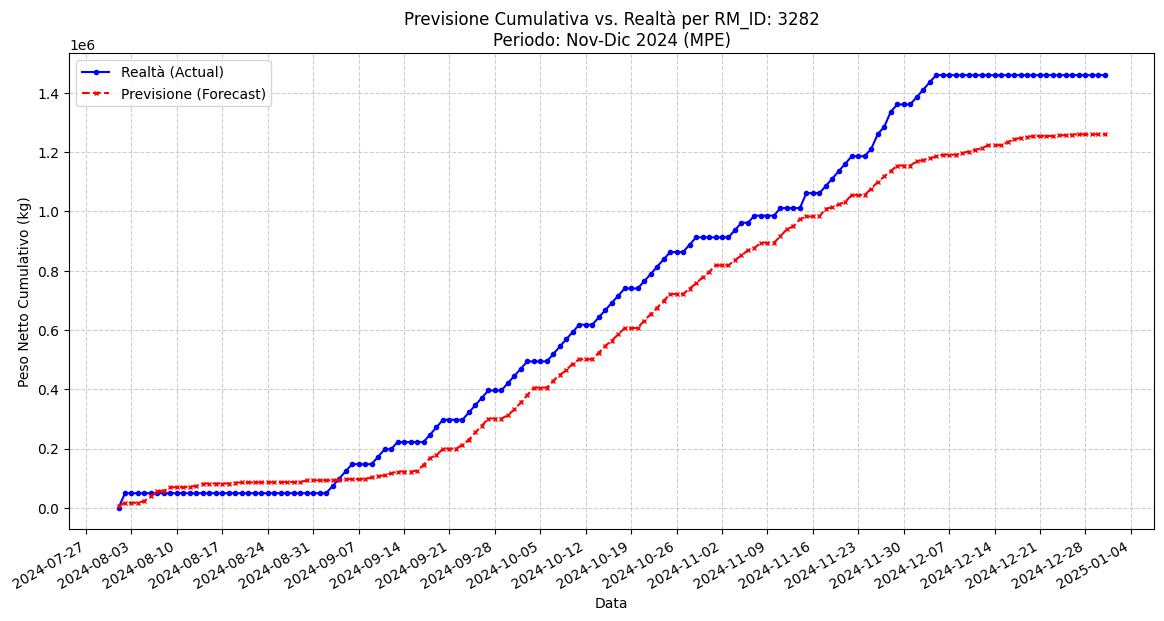

In [15]:
# --- 7. Plot di Debug (MPE) ---
print("\n--- Sezione 7: Plot di Debug su Set di Validazione (MPE) ---")

RM_ID_TO_PLOT = 3282 # Scegli un ID tra quelli ATTIVI
print(f"Generazione plot per rm_id: {RM_ID_TO_PLOT}...")

if not df_valid_results_mpe.empty and RM_ID_TO_PLOT in df_valid_results_mpe['rm_id'].unique():
    df_plot = df_valid_results_mpe[df_valid_results_mpe['rm_id'] == RM_ID_TO_PLOT].copy()
    
    df_plot.sort_values(by='date', inplace=True)
    # Rinomina colonna target originale per chiarezza
    df_plot.rename(columns={'net_weight': 'y_true'}, inplace=True) 
    df_plot['actual_cumulative'] = df_plot['y_true'].cumsum()
    df_plot['predicted_cumulative'] = df_plot['y_pred_daily'].cumsum()
    
    plt.figure(figsize=(14, 7))
    plt.plot(df_plot['date'], df_plot['actual_cumulative'], label='Realtà (Actual)', color='blue', marker='o', markersize=3, linestyle='-')
    plt.plot(df_plot['date'], df_plot['predicted_cumulative'], label='Previsione (Forecast)', color='red', marker='x', markersize=3, linestyle='--')
    plt.title(f'Previsione Cumulativa vs. Realtà per RM_ID: {RM_ID_TO_PLOT}\nPeriodo: Nov-Dic 2024 (MPE)')
    plt.ylabel('Peso Netto Cumulativo (kg)')
    plt.xlabel('Data')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
    plt.gcf().autofmt_xdate()

In [16]:
# --- 7. Analisi dei Materiali Peggiori ---
print("\n--- Sezione 7: Analisi dei Materiali Peggiori ---")

if validation_predictions:
    df_valid_results_mpe = pd.concat(validation_predictions, ignore_index=True)
    df_valid_cum_score_mpe = df_valid_results_mpe.groupby('rm_id').agg(
        A_i=('net_weight', 'sum'),
        F_i=('y_pred_daily', 'sum')
    ).reset_index()
    
    A_i = df_valid_cum_score_mpe['A_i']
    F_i = df_valid_cum_score_mpe['F_i']
    q = 0.2 
    quantile_loss_per_id = np.maximum(q * (A_i - F_i), (1 - q) * (F_i - A_i))
    
    df_error_analysis = pd.DataFrame({
        'rm_id': df_valid_cum_score_mpe['rm_id'],
        'Actual_Total_Weight': A_i,
        'Predicted_Total_Weight': F_i,
        'Quantile_Loss_0.2': quantile_loss_per_id
    })
    
    df_worst_performing = df_error_analysis.sort_values(by='Quantile_Loss_0.2', ascending=False)
    
    print("Classifica dei materiali con le previsioni peggiori (Ordinate per Quantile Loss 0.2):")
    print(df_worst_performing.head(10))
    
    df_worst_performing['Bias'] = np.where(df_worst_performing['Predicted_Total_Weight'] > df_worst_performing['Actual_Total_Weight'], 'Overstima', 'Sottostima')
    
    print("\nBias di Previsione dei Top 5:")
    print(df_worst_performing[['rm_id', 'Quantile_Loss_0.2', 'Bias']].head(5))


--- Sezione 7: Analisi dei Materiali Peggiori ---
Classifica dei materiali con le previsioni peggiori (Ordinate per Quantile Loss 0.2):
     rm_id  Actual_Total_Weight  Predicted_Total_Weight  Quantile_Loss_0.2
46    2130            8066725.0            6.065510e+06      400242.931274
94    3781            1962681.0            1.205742e+05      368421.355000
100   3901            1185240.0            4.415000e+03      236165.000000
72    3125            2229160.0            1.533751e+06      139081.733278
98    3865            3642151.0            3.082012e+06      112027.854850
115   4443             494980.0            0.000000e+00       98996.000000
50    2134             580659.0            1.158299e+05       92965.814450
108   4222             441500.0            0.000000e+00       88300.000000
81    3362             350898.0            0.000000e+00       70179.600000
54    2142             460879.0            1.245224e+05       67271.324246

Bias di Previsione dei Top 5:
     rm


--- Sezione 7: Analisi Feature Importance per RM_ID specifico ---
Top 20 feature più importanti per RM_ID: 3901
                feature  importance
2             dayofyear           5
14   lag_7_roll_mean_14           5
16  lag_30_roll_mean_90           2
11              lag_182           2
3                  year           2
0             dayofweek           1
4            weekofyear           1
6                 lag_7           0
7                lag_14           0
1                 month           0
9                lag_30           0
10               lag_91           0
5            is_weekend           0
12              lag_270           0
13              lag_364           0
15  lag_364_roll_mean_7           0
8                lag_28           0
Plot salvato come: feature_importance_rm3901.png


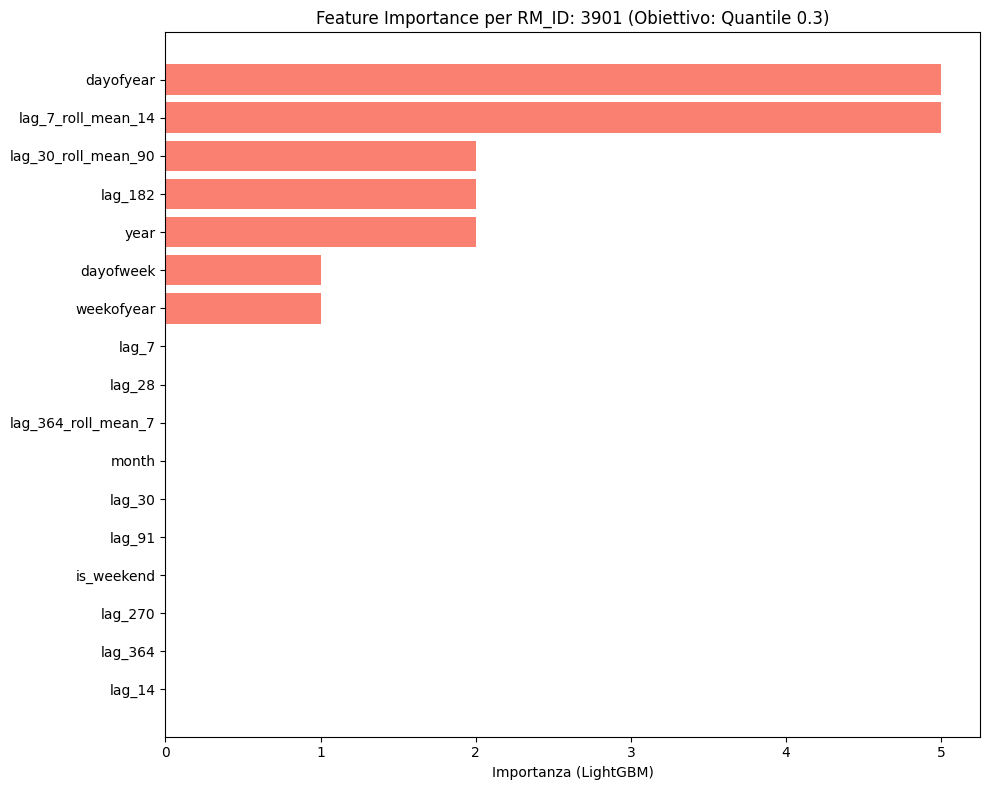

In [17]:
# --- CODICE AGGIUNTO/MODIFICATO (Assumiamo rm_id = 365 è il target) ---
RM_ID_FOR_DEBUG = 3901



# --- NUOVA SEZIONE 7: Analisi Feature Importance per Singolo RM ---
print("\n--- Sezione 7: Analisi Feature Importance per RM_ID specifico ---")

if RM_ID_FOR_DEBUG in mpe_models:
    model_debug = mpe_models[RM_ID_FOR_DEBUG]
    
    # 1. Estrai l'importanza delle feature
    df_importance_single = pd.DataFrame({
        'feature': mpe_features, # mpe_features è la lista corretta dal training
        'importance': model_debug.feature_importances_
    })

    # 2. Ordina e stampa
    df_importance_single = df_importance_single.sort_values(by='importance', ascending=False)
    
    print(f"Top 20 feature più importanti per RM_ID: {RM_ID_FOR_DEBUG}")
    print(df_importance_single.head(20))

    # 3. Plot
    df_plot_importance = df_importance_single.head(20).sort_values(by='importance', ascending=True)
    plt.figure(figsize=(10, 8))
    plt.barh(df_plot_importance['feature'], df_plot_importance['importance'], color='salmon')
    plt.xlabel("Importanza (LightGBM)")
    plt.title(f'Feature Importance per RM_ID: {RM_ID_FOR_DEBUG} (Obiettivo: Quantile 0.3)')
    plt.tight_layout()
    
    plot_filename = f'feature_importance_rm{RM_ID_FOR_DEBUG}.png'
    plt.savefig(plot_filename)
    print(f"Plot salvato come: {plot_filename}")

else:
    print(f"RM_ID {RM_ID_FOR_DEBUG} non era tra gli ID attivi o aveva dati insufficienti per l'addestramento.")

print("="*60)
# ... (Fine dello script)

In [18]:
# --- NUOVA SEZIONE 9: Analisi Input per RM_ID Specifico ---
print("\n--- Sezione 9: Analisi Input Giornalieri per RM_ID Specifico ---")

RM_ID_FOR_DEBUG = 3901 # <<< CAMBIA QUESTO ID SE NECESSARIO

# Verifica se abbiamo i risultati di validazione
if 'df_valid_results_mpe' in locals() and not df_valid_results_mpe.empty:
    
    # Filtra i risultati di validazione per l'rm_id
    df_debug_rm = df_valid_results_mpe[df_valid_results_mpe['rm_id'] == RM_ID_FOR_DEBUG].copy()
    
    if df_debug_rm.empty:
        print(f"Nessun risultato di validazione trovato per RM_ID {RM_ID_FOR_DEBUG}.")
    else:
        # Calcola l'errore giornaliero (Actual - Predicted)
        df_debug_rm['daily_error'] = df_debug_rm['net_weight'] - df_debug_rm['y_pred_daily']
        # Identifica i giorni con maggiore sottostima (errore positivo grande)
        df_debug_rm_worst_days = df_debug_rm.sort_values(by='daily_error', ascending=False).head(10)
        
        print(f"\nTop 10 giorni con maggiore SOTTOSTIMA per RM_ID {RM_ID_FOR_DEBUG} (Nov-Dic 2024):")
        print(df_debug_rm_worst_days[['date', 'net_weight', 'y_pred_daily', 'daily_error']])
        
        # Recupera le feature più importanti per questo rm_id (dalla Sezione 8)
        if RM_ID_FOR_DEBUG in mpe_models:
            model_debug = mpe_models[RM_ID_FOR_DEBUG]
            df_importance_single = pd.DataFrame({
                'feature': mpe_features,
                'importance': model_debug.feature_importances_
            }).sort_values(by='importance', ascending=False)
            
            top_features = df_importance_single['feature'].head(10).tolist()
            
            print(f"\nValori delle Top 10 Feature nei giorni di maggiore sottostima per RM_ID {RM_ID_FOR_DEBUG}:")
            
            # Recupera i dati di input originali per quei giorni
            # Dobbiamo ri-filtrare df_master_mpe perché df_valid_results_mpe non ha le feature
            df_input_features = df_master_mpe[
                (df_master_mpe['rm_id'] == RM_ID_FOR_DEBUG) &
                (df_master_mpe['date'].isin(df_debug_rm_worst_days['date']))
            ]
            
            # Seleziona e stampa le colonne rilevanti
            columns_to_show = ['date'] + top_features
            print(df_input_features[columns_to_show].round(2))
            
        else:
            print(f"Modello per RM_ID {RM_ID_FOR_DEBUG} non trovato per analisi feature.")

else:
    print("DataFrame dei risultati di validazione 'df_valid_results_mpe' non trovato.")

print("="*60)
print("Analisi input completata.")


--- Sezione 9: Analisi Input Giornalieri per RM_ID Specifico ---

Top 10 giorni con maggiore SOTTOSTIMA per RM_ID 3901 (Nov-Dic 2024):
            date  net_weight  y_pred_daily  daily_error
15385 2024-10-25     47940.0           0.0      47940.0
15403 2024-11-12     42920.0           0.0      42920.0
15378 2024-10-18     42880.0           0.0      42880.0
15368 2024-10-08     40800.0           0.0      40800.0
15353 2024-09-23     40620.0           0.0      40620.0
15410 2024-11-19     40460.0           0.0      40460.0
15371 2024-10-11     40380.0           0.0      40380.0
15437 2024-12-16     39180.0           0.0      39180.0
15374 2024-10-14     38280.0           0.0      38280.0
15388 2024-10-28     36760.0           0.0      36760.0

Valori delle Top 10 Feature nei giorni di maggiore sottostima per RM_ID 3901:
             date  dayofyear  lag_7_roll_mean_14  lag_30_roll_mean_90  \
773005 2024-09-23        267             8158.57              3990.56   
773020 2024-10-08      

In [19]:
# calcola la media di tutti i valori in submission_mpe_recursive.csv
mean_prediction = df_submission['predicted_weight'].mean()
print(f"\nMedia delle previsioni nel file di submission: {mean_prediction:.4f} kg")


Media delle previsioni nel file di submission: 46004.9905 kg
